<a href="https://colab.research.google.com/github/Buchi1996/Comparing-Accuracy-rate-of-Classification-Algorithms-in-Sentiment-Analysis/blob/main/EDA_2_Sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install langdetect
!pip install geopandas

     |████████████████████████████████| 981 kB 5.3 MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993242 sha256=9171fc2f5d7c312419e31b6ad54f8e0291dbbaf344bfd62ebc46649811b3b18c
  Stored in directory: /root/.cache/pip/wheels/c5/96/8a/f90c59ed25d75e50a8c10a1b1c2d4c402e4dacfa87f3aff36a
Successfully built langdetect
     |████████████████████████████████| 1.0 MB 5.1 MB/s 
     |████████████████████████████████| 15.4 MB 50.0 MB/s 
     |████████████████████████████████| 6.3 MB 53.1 MB/s 


imports

In [ ]:
import os
import time
import missingno as msno
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk, re, string, collections, unicodedata
import tensorflow as tf


%matplotlib inline
from matplotlib import cm, dates
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
from datetime import datetime, timedelta
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS
from langdetect import detect
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#EDA-1

Trump

In [ ]:
df1=pd.read_csv("/content/drive/MyDrive/MASTERS FOLDER/CS855/US_Elections_Data_Downloads/US_elections/hashtag_donaldtrump.csv", lineterminator='\n')
df1.head(2)

,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,user_join_date,user_followers_count,user_location,lat,long,city,country,continent,state,state_code,collected_at
0,2020-10-15 00:00:01,1.316529e+18,#Elecciones2020 | En #Florida: #JoeBiden dice ...,0.0,0.0,TweetDeck,360666534.0,El Sol Latino News,elsollatinonews,🌐 Noticias de interés para latinos de la costa...,2011-08-23 15:33:45,1860.0,"Philadelphia, PA / Miami, FL",25.77427,-80.19366,NaN,United States of America,North America,Florida,FL,2020-10-21 00:00:00
1,2020-10-15 00:00:01,1.316529e+18,"Usa 2020, Trump contro Facebook e Twitter: cop...",26.0,9.0,Social Mediaset,331617619.0,Tgcom24,MediasetTgcom24,Profilo ufficiale di Tgcom24: tutte le notizie...,2011-07-08 13:12:20,1067661.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:00.373216530


Biden

In [ ]:
df1=pd.read_csv("/content/drive/MyDrive/MASTERS FOLDER/CS855/US_Elections_Data_Downloads/US_elections/hashtag_joebiden.csv", lineterminator='\n')
df1.head(2)

,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,user_join_date,user_followers_count,user_location,lat,long,city,country,continent,state,state_code,collected_at
0,2020-10-15 00:00:01,1.316529e+18,#Elecciones2020 | En #Florida: #JoeBiden dice ...,0.0,0.0,TweetDeck,360666534.0,El Sol Latino News,elsollatinonews,🌐 Noticias de interés para latinos de la costa...,2011-08-23 15:33:45,1860.0,"Philadelphia, PA / Miami, FL",25.77427,-80.19366,NaN,United States of America,North America,Florida,FL,2020-10-21 00:00:00
1,2020-10-15 00:00:18,1.316529e+18,#HunterBiden #HunterBidenEmails #JoeBiden #Joe...,0.0,0.0,Twitter for iPad,809904438.0,Cheri A. 🇺🇸,Biloximeemaw,"Locked and loaded Meemaw. Love God, my family ...",2012-09-08 01:03:57,6628.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:00.517827283


In [ ]:
# Reading both the csv files
tweets_biden =pd.read_csv("/content/drive/MyDrive/MASTERS FOLDER/CS855/US_Elections_Data_Downloads/US_elections/hashtag_joebiden.csv", lineterminator='\n', parse_dates=True)
tweets_trump =pd.read_csv("/content/drive/MyDrive/MASTERS FOLDER/CS855/US_Elections_Data_Downloads/US_elections/hashtag_donaldtrump.csv", lineterminator='\n', parse_dates=True)

# Replace United states in country column with United States of America
tweets_biden['country'].replace({'United States':'United States of America'}, inplace=True)
tweets_trump['country'].replace({'United States':'United States of America'}, inplace=True)


# Add Features
def normalise(x,y):
    x = np.array(x)
    y = np.array(y)
    return np.where(x == 0, 0, x / y)

def sentiment(data):
    temp=[]
    for row in data:
        tmp=sid.polarity_scores(row)
        temp.append(tmp)
    return temp

# convert to datetime object
tweets_biden['user_join_date']=pd.to_datetime(tweets_biden['user_join_date'])
tweets_trump['user_join_date']=pd.to_datetime(tweets_trump['user_join_date'])
tweets_biden['collected_at']=pd.to_datetime(tweets_biden['collected_at'])
tweets_trump['collected_at']=pd.to_datetime(tweets_trump['collected_at'])
tweets_biden['created_at']=pd.to_datetime(tweets_biden['created_at'])
tweets_trump['created_at']=pd.to_datetime(tweets_trump['created_at'])

# create additional date time columns
tweets_biden['created_at_r']=tweets_biden['created_at'].dt.strftime('%Y-%m-%d %H')
tweets_trump['created_at_r']=tweets_trump['created_at'].dt.strftime('%Y-%m-%d %H')
tweets_biden['created_at_r2']=tweets_biden['created_at'].dt.strftime('%m-%d')
tweets_trump['created_at_r2']=tweets_trump['created_at'].dt.strftime('%m-%d')

# normalise time diff to hours
b_tdiff=(tweets_biden['collected_at'] - tweets_biden['created_at'])
t_tdiff=(tweets_trump['collected_at'] - tweets_trump['created_at'])
b_tdiff=(b_tdiff.dt.days * 24 + b_tdiff.dt.seconds / 3600)
t_tdiff=(t_tdiff.dt.days * 24 + t_tdiff.dt.seconds / 3600)

# Use numpy vectorisation to create new columns for normalised likes and retweets
tweets_biden['likes_norm'] = normalise(tweets_biden['likes'],b_tdiff)
tweets_biden['retweet_norm'] = normalise(tweets_biden['retweet_count'],b_tdiff)
tweets_trump['likes_norm'] = normalise(tweets_trump['likes'],t_tdiff)
tweets_trump['retweet_norm'] = normalise(tweets_trump['retweet_count'],t_tdiff)

tweets_biden.tail(2)


,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,user_join_date,user_followers_count,user_location,lat,long,city,country,continent,state,state_code,collected_at,created_at_r,created_at_r2,likes_norm,retweet_norm
776884,2020-11-08 23:59:52,1.325589e+18,🌎\n\n“#congiuntifuoriregione”\n\n‘Sono felice ...,1.0,1.0,Twitter for iPhone,529331509.0,Angelo Tani,AngeloTani,nato a casa dei nonni,2012-03-19 12:07:06,5974.0,🌎,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-11-09 18:32:45.599846,2020-11-08 23,11-08,0.053914,0.053914
776885,2020-11-08 23:59:58,1.325589e+18,"Ik moet zeggen dat ik #Biden ""the lesser of tw...",0.0,0.0,Twitter for Android,586386345.0,Job,_JobO__,-voeg hier uw interessante bio toe-,2012-05-21 06:30:14,119.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-11-09 18:32:45.747707,2020-11-08 23,11-08,0.000000,0.000000


Visualizations

In [ ]:
# Visualisation functions
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
barcolors = ['#87B88C','#9ED2A1','#E7E8CB','#48A0C9','#2A58A1','#2E8B55','#DF3659','Grey']
barstyle = {"edgecolor":"black", "linewidth":1}
heatmap1_args = dict(annot=True, fmt='.0f', square=False, cmap=cm.get_cmap("RdGy", 10), center = 90, vmin=0, vmax=10000, lw=4, cbar=False)
heatmap2_args = dict(annot=True, fmt='.3f', square=False, cmap="Greens", center = 0.5, lw=4, cbar=False)
heatmap3_args = dict(annot=True, fmt='.0f', square=False, cmap=cmap, center = 9200, lw=4, cbar=False)

def hide_axes(this_ax):
    this_ax.set_frame_on(False)
    this_ax.set_xticks([])
    this_ax.set_yticks([])
    return this_ax

def draw_heatmap1(df,this_ax):
    hm = sns.heatmap(df, ax = this_ax, **heatmap1_args)
    this_ax.set_yticklabels(this_ax.get_yticklabels(), rotation=0)
    this_ax.yaxis.tick_right()
    this_ax.yaxis.set_label_position("right")
    for axis in ['top','bottom','left','right']:
        this_ax.spines[axis].set_visible(True)
        this_ax.spines[axis].set_color('black')
    return hm 

def draw_heatmap2(df,this_ax):
    hm = sns.heatmap(df, ax = this_ax, **heatmap2_args)
    this_ax.set_yticklabels(this_ax.get_yticklabels(), rotation=0)
    this_ax.yaxis.tick_right()
    this_ax.yaxis.set_label_position("right")
    for axis in ['top','bottom','left','right']:
        this_ax.spines[axis].set_visible(True)
        this_ax.spines[axis].set_color('black')
    return hm 

def draw_heatmap3(df,this_ax):
    hm = sns.heatmap(df, ax = this_ax, **heatmap3_args)
    this_ax.set_yticklabels(this_ax.get_yticklabels(), rotation=0)
    this_ax.yaxis.tick_right()
    this_ax.yaxis.set_label_position("right")
    for axis in ['top','bottom','left','right']:
        this_ax.spines[axis].set_visible(True)
        this_ax.spines[axis].set_color('black')
    return hm 

def thousands1(x, pos):
    'The two args are the value and tick position'
    return '%1.0fK' % (x * 1e-3)

formatterK1 = FuncFormatter(thousands1)

def thousands2(x, pos):
    'The two args are the value and tick position'
    return '%1.1fK' % (x * 1e-3)

formatterK2 = FuncFormatter(thousands2)


Null Value Analysis

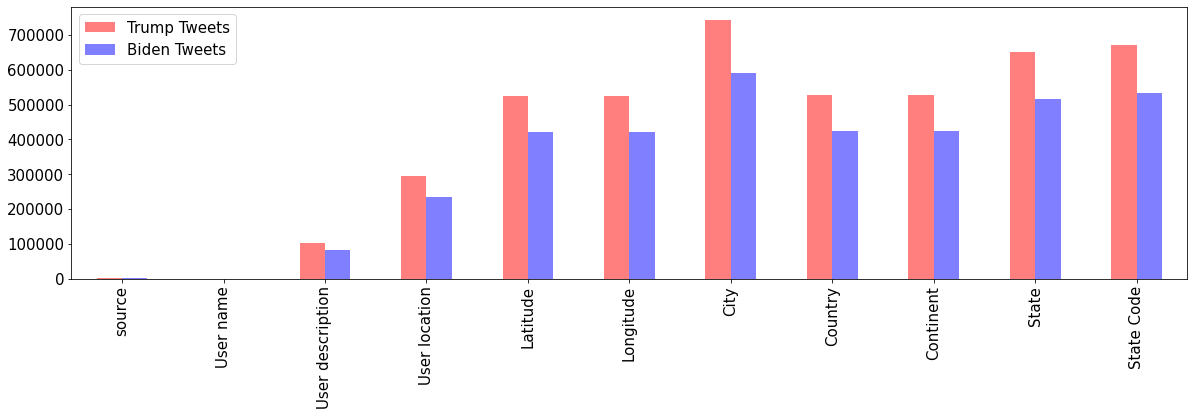

In [ ]:
df = pd.DataFrame({
    'States': ['source', 'User name', 'User description', 'User location','Latitude','Longitude','City','Country','Continent','State','State Code'],
    'Trump Tweets': [876, 16, 101266, 294953, 525200, 525200, 743732, 528171, 528154, 650299, 670494],
    'Biden Tweets': [713, 18, 82006, 233791, 421593, 421593, 590014, 423107, 423089, 516691, 532277]
})

colours = ['r', 'b'][0:len(df.columns)]
ax =df.plot(x="States", y=["Trump Tweets", "Biden Tweets"], kind="bar",color=colours,alpha=0.5)
# df.plot(figsize=(7,3))
ax.set_xlabel("")
plt.rcParams["figure.figsize"] = [20, 5]
plt.rcParams.update({'font.size': 15})


Null values in Trump and Biden CSVs

[876, 16, 101266, 294953, 525200, 525200, 743732, 528171, 528154, 650299, 670494]


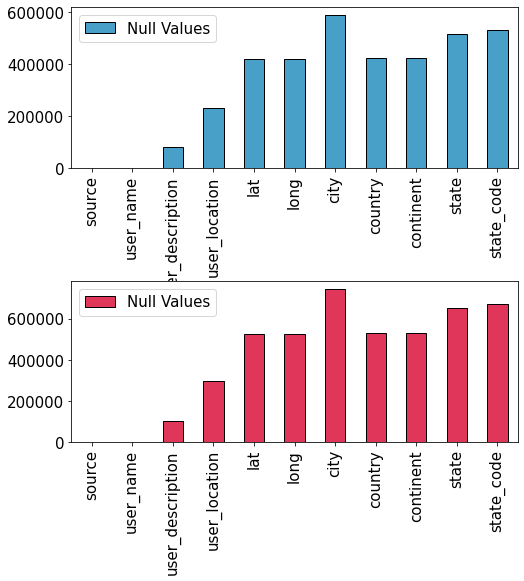

<Figure size 1440x360 with 0 Axes>

In [ ]:
na_vals_b=pd.DataFrame({'Null Values':tweets_biden.isna().sum()})
na_vals_b=na_vals_b.loc[na_vals_b['Null Values'] > 0]
na_vals_t=pd.DataFrame({'Null Values':tweets_trump.isna().sum()})
na_vals_t=na_vals_t.loc[na_vals_t['Null Values'] > 0]
print(na_vals_t["Null Values"].tolist())

performance = [[na_vals_b,na_vals_t]]
# Null values visualisation for tweets about Joe Biden and Donald Trump
fig, ax=plt.subplots(2,1, figsize=(8,8), gridspec_kw={'hspace':0.7})

na_vals_b.plot.bar(color=barcolors[3], **barstyle, ax=ax[0])
# ax[0].set_title('Joe Biden Dataset')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)
na_vals_t.plot.bar(color=barcolors[6], **barstyle, ax=ax[1])
# ax[1].set_title('Donald Trump Dataset')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)
plt.show()


fig1 = plt.figure()

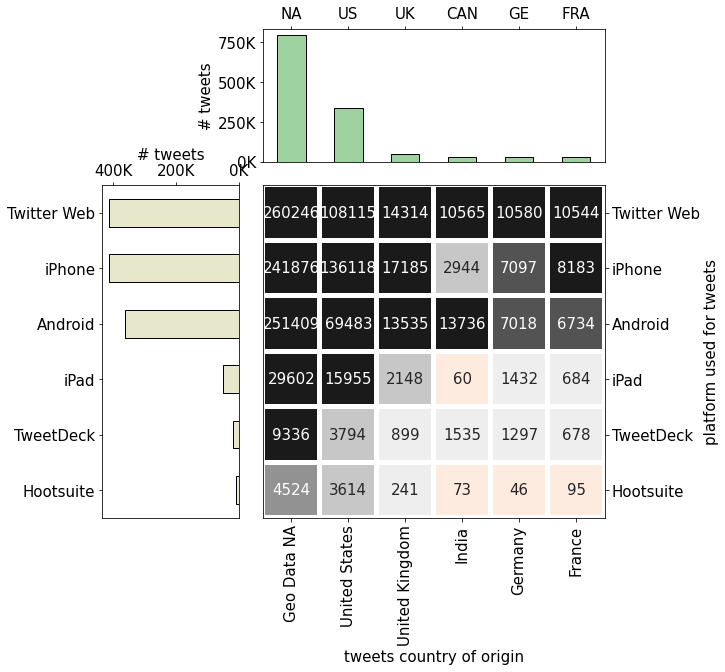

In [ ]:
# Code taken from https://www.kaggle.com/tkubacka/a-story-told-through-a-heatmap

source_df=pd.concat([tweets_biden[['source','tweet','country']].copy(),tweets_trump[['source','tweet','country']].copy()])
source_df['country'].replace({'United States of America':'United States'}, inplace=True)
source_df=source_df.fillna('Geo Data NA')
source_df=source_df.drop_duplicates()

sources=pd.DataFrame(source_df.groupby(['source'])['tweet'].count().sort_values(ascending=False)[:6])
sources=sources.reset_index()
sourceslst=sources.source.to_list()

country=pd.DataFrame(source_df.groupby(['country'])['tweet'].count().sort_values(ascending=False)[:6])
country=country.reset_index()
countrylst=country.country.to_list()

platXtab=pd.DataFrame(source_df.groupby(['source','country'])['tweet'].count().unstack().fillna(0))

fig, ax=plt.subplots(2,2, figsize=(9,9), 
                     gridspec_kw={'height_ratios':[2,5], 'width_ratios':[2,5], 'wspace':0.1, 'hspace':0.1})

hide_ax = ax[0,0]
hide_axes(hide_ax)

hm_ax = ax[1,1]
draw_heatmap1(platXtab.loc[sourceslst,countrylst], hm_ax)
hm_ax.set_xlabel('tweets country of origin')
hm_ax.set_ylabel('platform used for tweets')
hm_ax.set_yticklabels(('Twitter Web','iPhone','Android','iPad','TweetDeck','Hootsuite'), rotation=0) 

bar_ax = ax[0,1]
platXtab.loc[sourceslst,countrylst].sum().plot.bar(ax=bar_ax, color=barcolors[1],**barstyle)
bar_ax.set_xlabel(bar_ax.get_xlabel())
bar_ax.xaxis.tick_top()
bar_ax.xaxis.set_label_position("top")
bar_ax.yaxis.set_major_formatter(formatterK1)
bar_ax.set_xticklabels(('NA', 'US', 'UK', 'CAN', 'GE','FRA'), rotation=0) 
bar_ax.set_xlabel('')
bar_ax.set_ylabel('# tweets')

barh_ax = ax[1,0]
platXtab.loc[sourceslst,countrylst].sum(axis=1)[::-1].plot.barh(ax=barh_ax, color=barcolors[2],**barstyle)
barh_ax.yaxis.set_label_position("left")
barh_ax.xaxis.tick_top()
barh_ax.xaxis.set_label_position("top")
barh_ax.xaxis.set_major_formatter(formatterK1)
barh_ax.set_xlim(barh_ax.get_xlim()[::-1])
barh_ax.set_yticklabels(('Hootsuite','TweetDeck','iPad','Android','iPhone','Twitter Web'), rotation=0) 
barh_ax.set_xlabel('# tweets')
barh_ax.set_ylabel('')
plt.show()

Geological Visualization

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


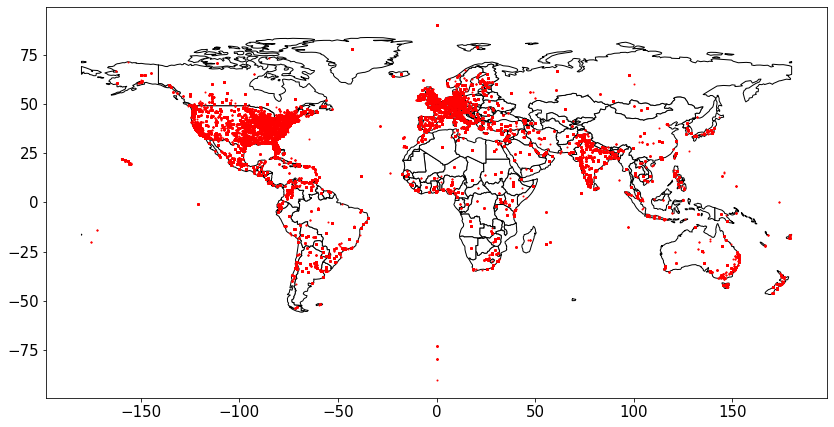

In [ ]:
world=gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
from shapely.geometry import Point, Polygon
crs = {'init': 'EPSG:4326'}

tmp=pd.concat([tweets_biden[['lat','long']].copy(),tweets_trump[['lat','long']].copy()])
tmp=tmp.dropna()
geometry = [Point(xy) for xy in zip(tmp['long'],tmp['lat'])]
geo_df=gpd.GeoDataFrame(tmp, crs=crs, geometry = geometry)


# Comment out this code if you have visualized the result
fig, ax = plt.subplots(1,figsize=(14,14), facecolor='white')
world = world[world.name != "Antarctica"]
world.plot(ax=ax, color='white', edgecolors='black')
geo_df.plot(ax=ax, markersize=1, color='r', marker='o')
ax.axis('on')
plt.show()

In [ ]:
%%time
def detect_tweetlang(tweet):
    try:
        return detect(tweet)
    except:
        return 'unknown'

# Combine two data files and drop duplicates
lang_df=pd.concat([tweets_biden[['tweet','country']].copy(),tweets_trump[['tweet','country']].copy()])
lang_df['country'].replace({'United States of America':'United States'}, inplace=True)
lang_df=lang_df.fillna('Geo Data NA')
lang_df=lang_df.drop_duplicates()

# Randomly sample data for langauge analysis
lang_smdf=lang_df.sample(n=4000).copy()
lang_smdf['lang'] = lang_smdf['tweet'].apply(detect_tweetlang)

# Select top five languages and five countries for heatmap
langs=pd.DataFrame(lang_smdf.groupby(['lang'])['tweet'].count().sort_values(ascending=False)[:5])
langs=langs.reset_index()
langslst=langs.lang.to_list()

country=pd.DataFrame(lang_smdf.groupby(['country'])['tweet'].count().sort_values(ascending=False)[:5])
country=country.reset_index()
countrylst=country.country.to_list()

# Create a crosstab to feed data to heatmap
langXtab=pd.crosstab(lang_smdf.lang, lang_smdf.country, normalize=True)

CPU times: user 41.9 s, sys: 320 ms, total: 42.2 s
Wall time: 42.2 s


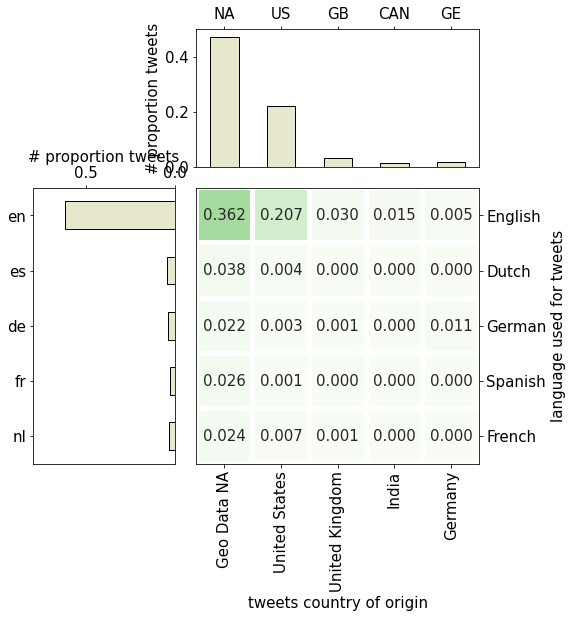

In [ ]:
fig, ax=plt.subplots(2,2, figsize=(8,8), 
                     gridspec_kw={'height_ratios':[2,4], 'width_ratios':[2,4], 'wspace':0.1, 'hspace':0.1})

hide_ax = ax[0,0]
hide_axes(hide_ax)

hm_ax = ax[1,1]
draw_heatmap2(langXtab.loc[langslst,countrylst], hm_ax)
hm_ax.set_yticklabels(('English', 'Dutch', 'German','Spanish','French'), rotation=0) 
hm_ax.set_xlabel('tweets country of origin')
hm_ax.set_ylabel('language used for tweets')

bar_ax = ax[0,1]
langXtab.loc[langslst,countrylst].sum().plot.bar(ax=bar_ax, color=barcolors[2],**barstyle)
bar_ax.set_xlabel(bar_ax.get_xlabel())
bar_ax.xaxis.tick_top()
bar_ax.xaxis.set_label_position("top")
bar_ax.set_xticklabels(('NA','US', 'GB', 'CAN', 'GE', 'FRA'), rotation=0) 
bar_ax.set_ylim([0, 0.5])
bar_ax.set_xlabel('')
bar_ax.set_ylabel('# proportion tweets')

barh_ax = ax[1,0]
langXtab.loc[langslst,countrylst].sum(axis=1)[::-1].plot.barh(ax=barh_ax, color=barcolors[2],**barstyle)
barh_ax.yaxis.set_label_position("left")
barh_ax.xaxis.tick_top()
barh_ax.xaxis.set_label_position("top")
barh_ax.set_xlim(barh_ax.get_xlim()[::-1])
barh_ax.set_xlim([0.8, 0])
barh_ax.set_xlabel('# proportion tweets')
barh_ax.set_ylabel('')
barh_ax.set_yticklabels(langslst[::-1], rotation=0) 

plt.show()

In [ ]:
# Identify the common UserId's in both datasets and create tables for feed visualisation
common_ids=np.intersect1d(tweets_biden.user_id, tweets_trump.user_id)
unique_b=tweets_biden[~tweets_biden.user_id.isin(common_ids)].copy()
common_b=tweets_biden[tweets_biden.user_id.isin(common_ids)].copy()
unique_t=tweets_trump[~tweets_trump.user_id.isin(common_ids)].copy()
common_t=tweets_trump[tweets_trump.user_id.isin(common_ids)].copy()

common_df=pd.concat([common_b,common_t])
common_df=common_df.drop_duplicates()

# Create columns for visualiation
unique_b['usertype'] = 'Biden'
unique_t['usertype'] = 'Trump'
common_df['usertype'] = 'Both'

# Narrow down data
cont_df=pd.concat([unique_b[['tweet','continent','usertype']].copy(),
                   unique_t[['tweet','continent','usertype']].copy(),
                   common_df[['tweet','continent','usertype']].copy()])

# Label NA Geo Data
cont_df=cont_df.fillna('Geo Data NA')

# Calculate tweet counts for each usertype and continuent
usertype=pd.DataFrame(cont_df.groupby(['usertype'])['tweet'].count().sort_values(ascending=False))
usertype=usertype.reset_index()
userlst=usertype.usertype.tolist()

continent=pd.DataFrame(cont_df.groupby(['continent'])['tweet'].count().sort_values(ascending=False)[:6])
continent=continent.reset_index()
contlst=continent.continent.to_list()

# Create crosstab to feed heatmap
contXtab=pd.crosstab(cont_df.continent, cont_df.usertype)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


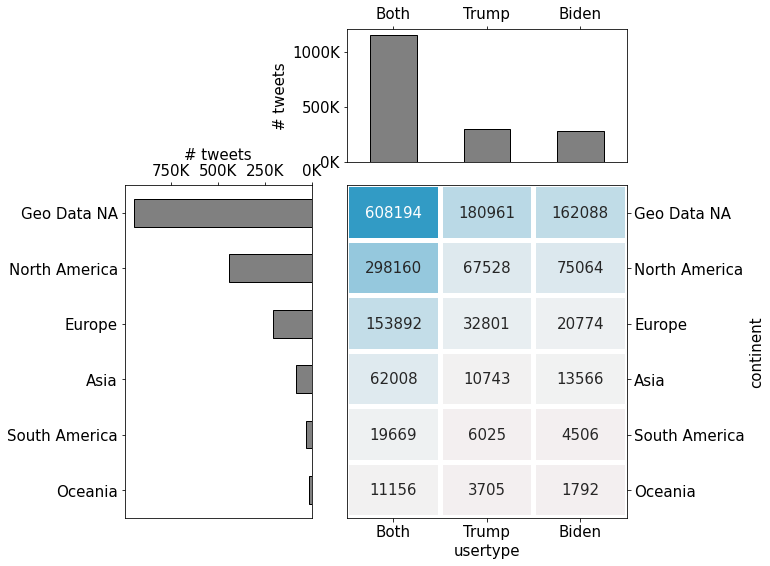

In [ ]:
fig, ax=plt.subplots(2,2, figsize=(9,9), 
                     gridspec_kw={'height_ratios':[2,5], 'width_ratios':[2,3], 'wspace':0.15, 'hspace':0.1})

hide_ax = ax[0,0]
hide_axes(hide_ax)

hm_ax = ax[1,1]
draw_heatmap3(contXtab.loc[contlst,userlst], hm_ax)
# hm_ax.set_xlabel('UserId Membership')
# hm_ax.set_ylabel('tweets continent of origin')

bar_ax = ax[0,1]
contXtab.loc[contlst,userlst].sum().plot.bar(ax=bar_ax, color=barcolors[7],**barstyle)
bar_ax.set_xlabel(bar_ax.get_xlabel())
bar_ax.xaxis.tick_top()
bar_ax.xaxis.set_label_position("top")
bar_ax.yaxis.set_major_formatter(formatterK1)
bar_ax.set_ylabel('# tweets')
bar_ax.set_xlabel('')

barh_ax = ax[1,0]
contXtab.loc[contlst,userlst].sum(axis=1)[::-1].plot.barh(ax=barh_ax, color=barcolors[7],**barstyle)
barh_ax.yaxis.set_label_position("left")
barh_ax.xaxis.tick_top()
barh_ax.xaxis.set_label_position("top")
barh_ax.xaxis.set_major_formatter(formatterK1)
barh_ax.set_xlim(barh_ax.get_xlim()[::-1])
barh_ax.set_xlabel('# tweets')
barh_ax.set_ylabel('')

plt.show()

In [ ]:
# Identify common tweet creation dates
common_creat=np.intersect1d(tweets_biden.created_at_r, tweets_trump.created_at_r)

# Mask out data to ensure common lenth arrays to feed visualisation
cnt_tbiden=tweets_biden[tweets_biden.created_at_r.isin(common_creat)]['created_at_r'].value_counts().sort_index()
cnt_ttrump=tweets_trump[tweets_trump.created_at_r.isin(common_creat)]['created_at_r'].value_counts().sort_index()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


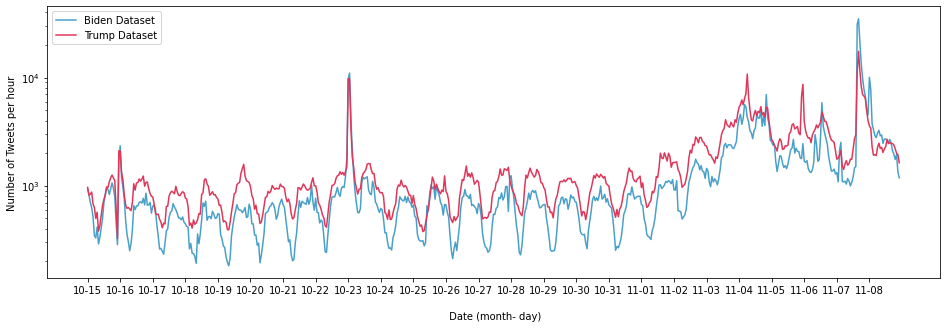

In [ ]:
plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(16,5))
p6=sns.lineplot(cnt_tbiden.index, cnt_tbiden.values, color=barcolors[3], label='Biden Dataset')
# p6.set_title('Count of tweets per hour')
p6=sns.lineplot(cnt_ttrump.index, cnt_ttrump.values, color=barcolors[6], label='Trump Dataset')
p6.set_xlabel("\n Date (month- day)")
p6.set_ylabel("Number of Tweets per hour")
p6.set_xticks(range(0, len(cnt_tbiden.index), 24))
p6.set_xticklabels(common_df['created_at'].dt.strftime('%m-%d').unique().tolist())
p6.set_yscale('log')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


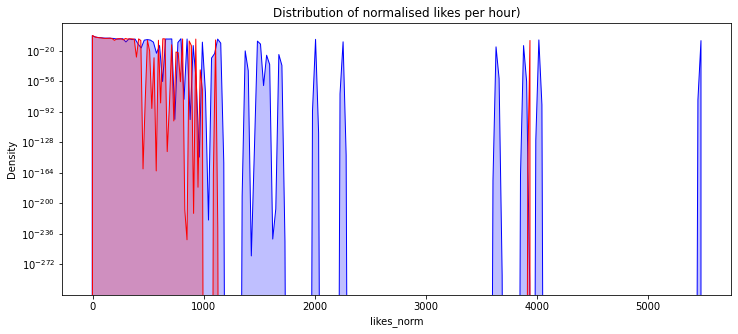

In [ ]:
fig, ax=plt.subplots(1,1, figsize=(12,5))

line_ax = ax
line_ax.set_title('Distribution of normalised likes per hour)')
sns.kdeplot(tweets_biden['likes_norm'],bw=0.1, shade=True, color='b', label='Biden Dataset', ax=line_ax)
sns.kdeplot(tweets_trump['likes_norm'],bw=0.1, shade=True, color='r', label='Trump Dataset', ax=line_ax)
line_ax.set_yscale('log')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


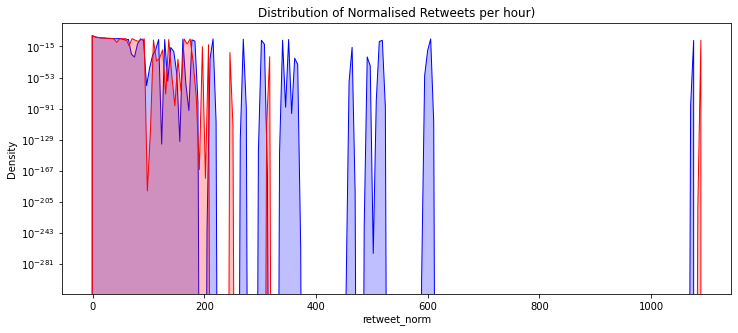

In [ ]:
fig, ax=plt.subplots(1,1, figsize=(12,5))

line_ax = ax
line_ax.set_title('Distribution of Normalised Retweets per hour)')
sns.kdeplot(tweets_biden['retweet_norm'],bw=0.1, shade=True, color='b', label='Biden Dataset', ax=line_ax)
sns.kdeplot(tweets_trump['retweet_norm'],bw=0.1, shade=True, color='r', label='Trump Dataset', ax=line_ax)
line_ax.set_yscale('log')
plt.show()

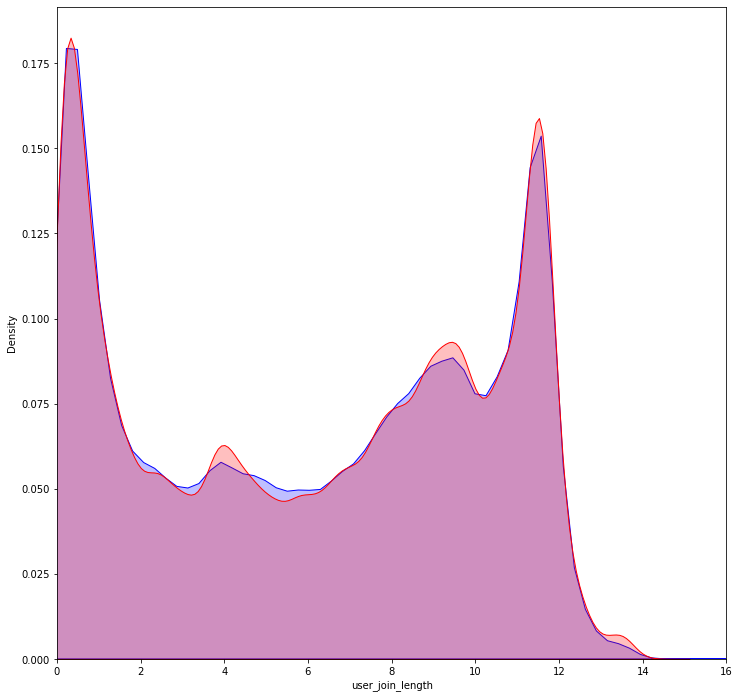

In [ ]:
fig, ax=plt.subplots(1,1, figsize=(12,12))
tweets_biden['user_join_length'] = max(tweets_biden['created_at']) - tweets_biden['user_join_date']
tweets_trump['user_join_length'] = max(tweets_trump['created_at']) - tweets_trump['user_join_date']

line_ax = ax
plt.xlim(0, 16)
# line_ax.set_title('Distribution of Years Since Joining')
sns.kdeplot(tweets_biden['user_join_length'].dt.days/365.25, shade=True, color='b', label='Biden Dataset', ax=line_ax, legend = True)
sns.kdeplot(tweets_trump['user_join_length'].dt.days/365.25, shade=True, color='r', label='Trump Dataset', ax=line_ax)
plt.show()

Texts

In [ ]:
text1=tweets_biden.loc[tweets_biden['country'] == 'United States of America']['tweet']
text2=tweets_trump.loc[tweets_trump['country'] == 'United States of America']['tweet']

**Data Cleaning**

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

**Cleaned Data**

In [ ]:
text1=tweets_biden.loc[tweets_biden['country'] == 'United States of America']['tweet']
text2=tweets_trump.loc[tweets_trump['country'] == 'United States of America']['tweet']
def clean1(sent):
    filtered_sent=""
    stopwords = nltk.corpus.stopwords.words('english')
    sent = (unicodedata.normalize('NFKD', sent)
            .encode('ascii', 'ignore')
            .decode('utf-8', 'ignore')
            .lower())
    sent = re.sub(r'#.+|https.+|[^(a-zA-Z)\s]','',sent)
    words=sent.split()
    for word in words:
        if word not in stopwords:
            filtered_sent=filtered_sent+' '+word
    return filtered_sent

def clean2(text):
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english')
    text = (unicodedata.normalize('NFKD', text)
            .encode('ascii', 'ignore')
            .decode('utf-8', 'ignore')
            .lower())
    words = re.sub(r'[^\w\s]', ' ', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

words1 = clean2(''.join(str(text1.apply(clean1).tolist())))
words2 = clean2(''.join(str(text2.apply(clean1).tolist())))
words1[:15]

['islandgirlprv',
 'bradbeauregardj',
 'meidastouch',
 'ccp',
 'thats',
 'always',
 'fine',
 'jack',
 'vijaya',
 'dickc',
 'katies',
 'marciadorsey',
 'jack',
 'sick',
 'fbi']

**top 10 bi and tri Ngrams from cleaned data**

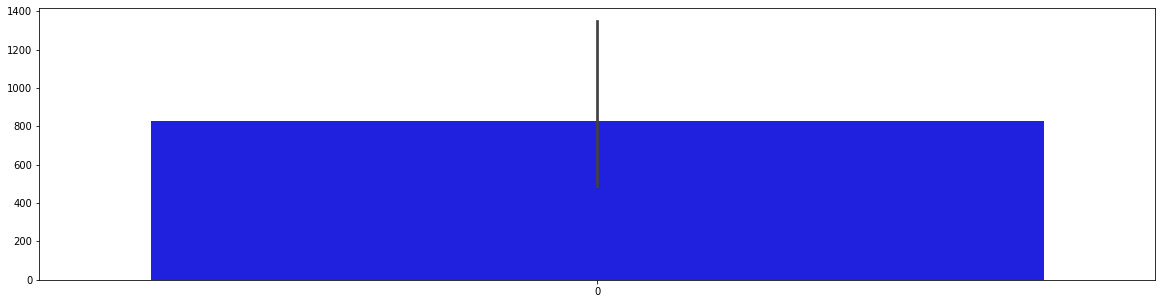

In [ ]:
biden_2ngrams=(pd.Series(nltk.ngrams(words1, 2)).value_counts())[:10]
trump_2ngrams=(pd.Series(nltk.ngrams(words2, 2)).value_counts())[:10]
biden_3ngrams=(pd.Series(nltk.ngrams(words1, 3)).value_counts())[:10]
trump_3ngrams=(pd.Series(nltk.ngrams(words2, 3)).value_counts())[:10]

# Input Bi and Tri Ngrams into dataframes for plotting
biden_ngrams=pd.concat([biden_2ngrams,biden_3ngrams])
trump_ngrams=pd.concat([trump_2ngrams,trump_3ngrams])

ax = sns.barplot(data=biden_ngrams
            , color="b")

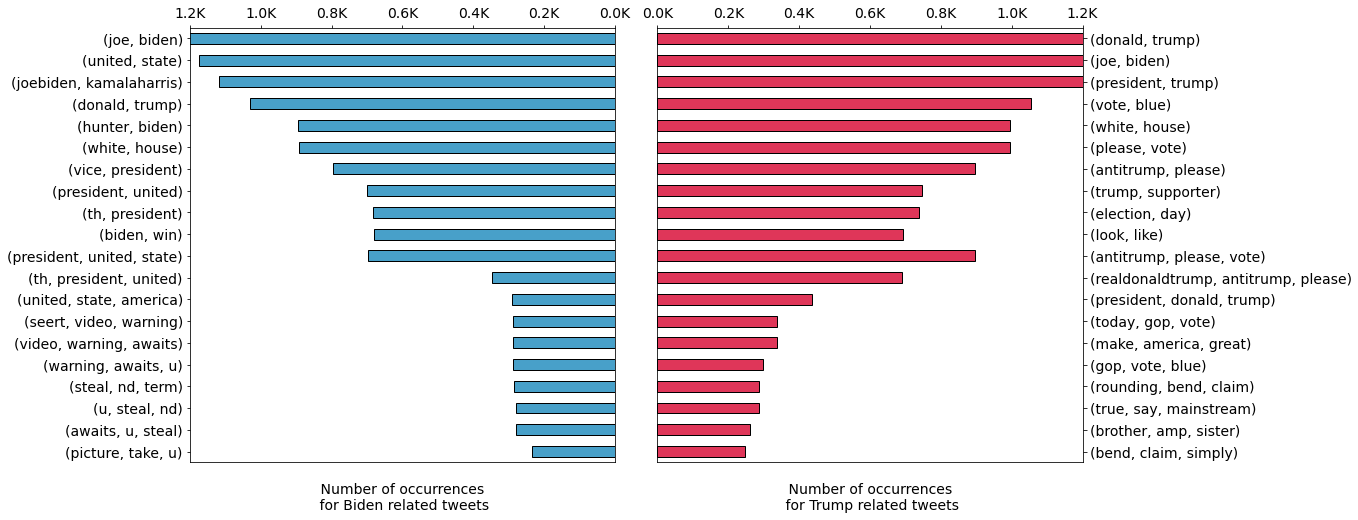

In [ ]:
plt.rcParams.update({'font.size': 14})
fig, ax=plt.subplots(1,2, figsize=(16,8), gridspec_kw = {'width_ratios':[1,1], 'wspace':0.1, 'hspace':0.1})

barh_ax = ax[0]
biden_ngrams[::-1].plot.barh(ax=barh_ax, color=barcolors[3],**barstyle)
barh_ax.yaxis.set_label_position("left")
barh_ax.xaxis.tick_top()
barh_ax.xaxis.set_label_position("bottom")
barh_ax.xaxis.set_major_formatter(formatterK2)
barh_ax.set_xlim([0, 1200])
barh_ax.set_xlim(barh_ax.get_xlim()[::-1])
barh_ax.set_xlabel('\n Number of occurrences \n for Biden related tweets')
# barh_ax.set_xlabel('Tri N-gram Count - Biden Dataset', fontsize=13)
barh_ax.set_ylabel('',fontsize=50)

barh_ax = ax[1]
trump_ngrams[::-1].plot.barh(ax=barh_ax, color=barcolors[6],**barstyle)
barh_ax.xaxis.tick_top()
barh_ax.xaxis.set_label_position("bottom")
barh_ax.xaxis.set_major_formatter(formatterK2)
barh_ax.set_xlim([0, 1200])
barh_ax.set_xlim(barh_ax.get_xlim())
barh_ax.yaxis.tick_right()
# barh_ax.set_xlabel('Tri N-gram Count - Trump Dataset', fontsize=13)
barh_ax.set_ylabel('', fontsize=50)
barh_ax.set_xlabel('\n Number of occurrences \n for Trump related tweets')
plt.show()

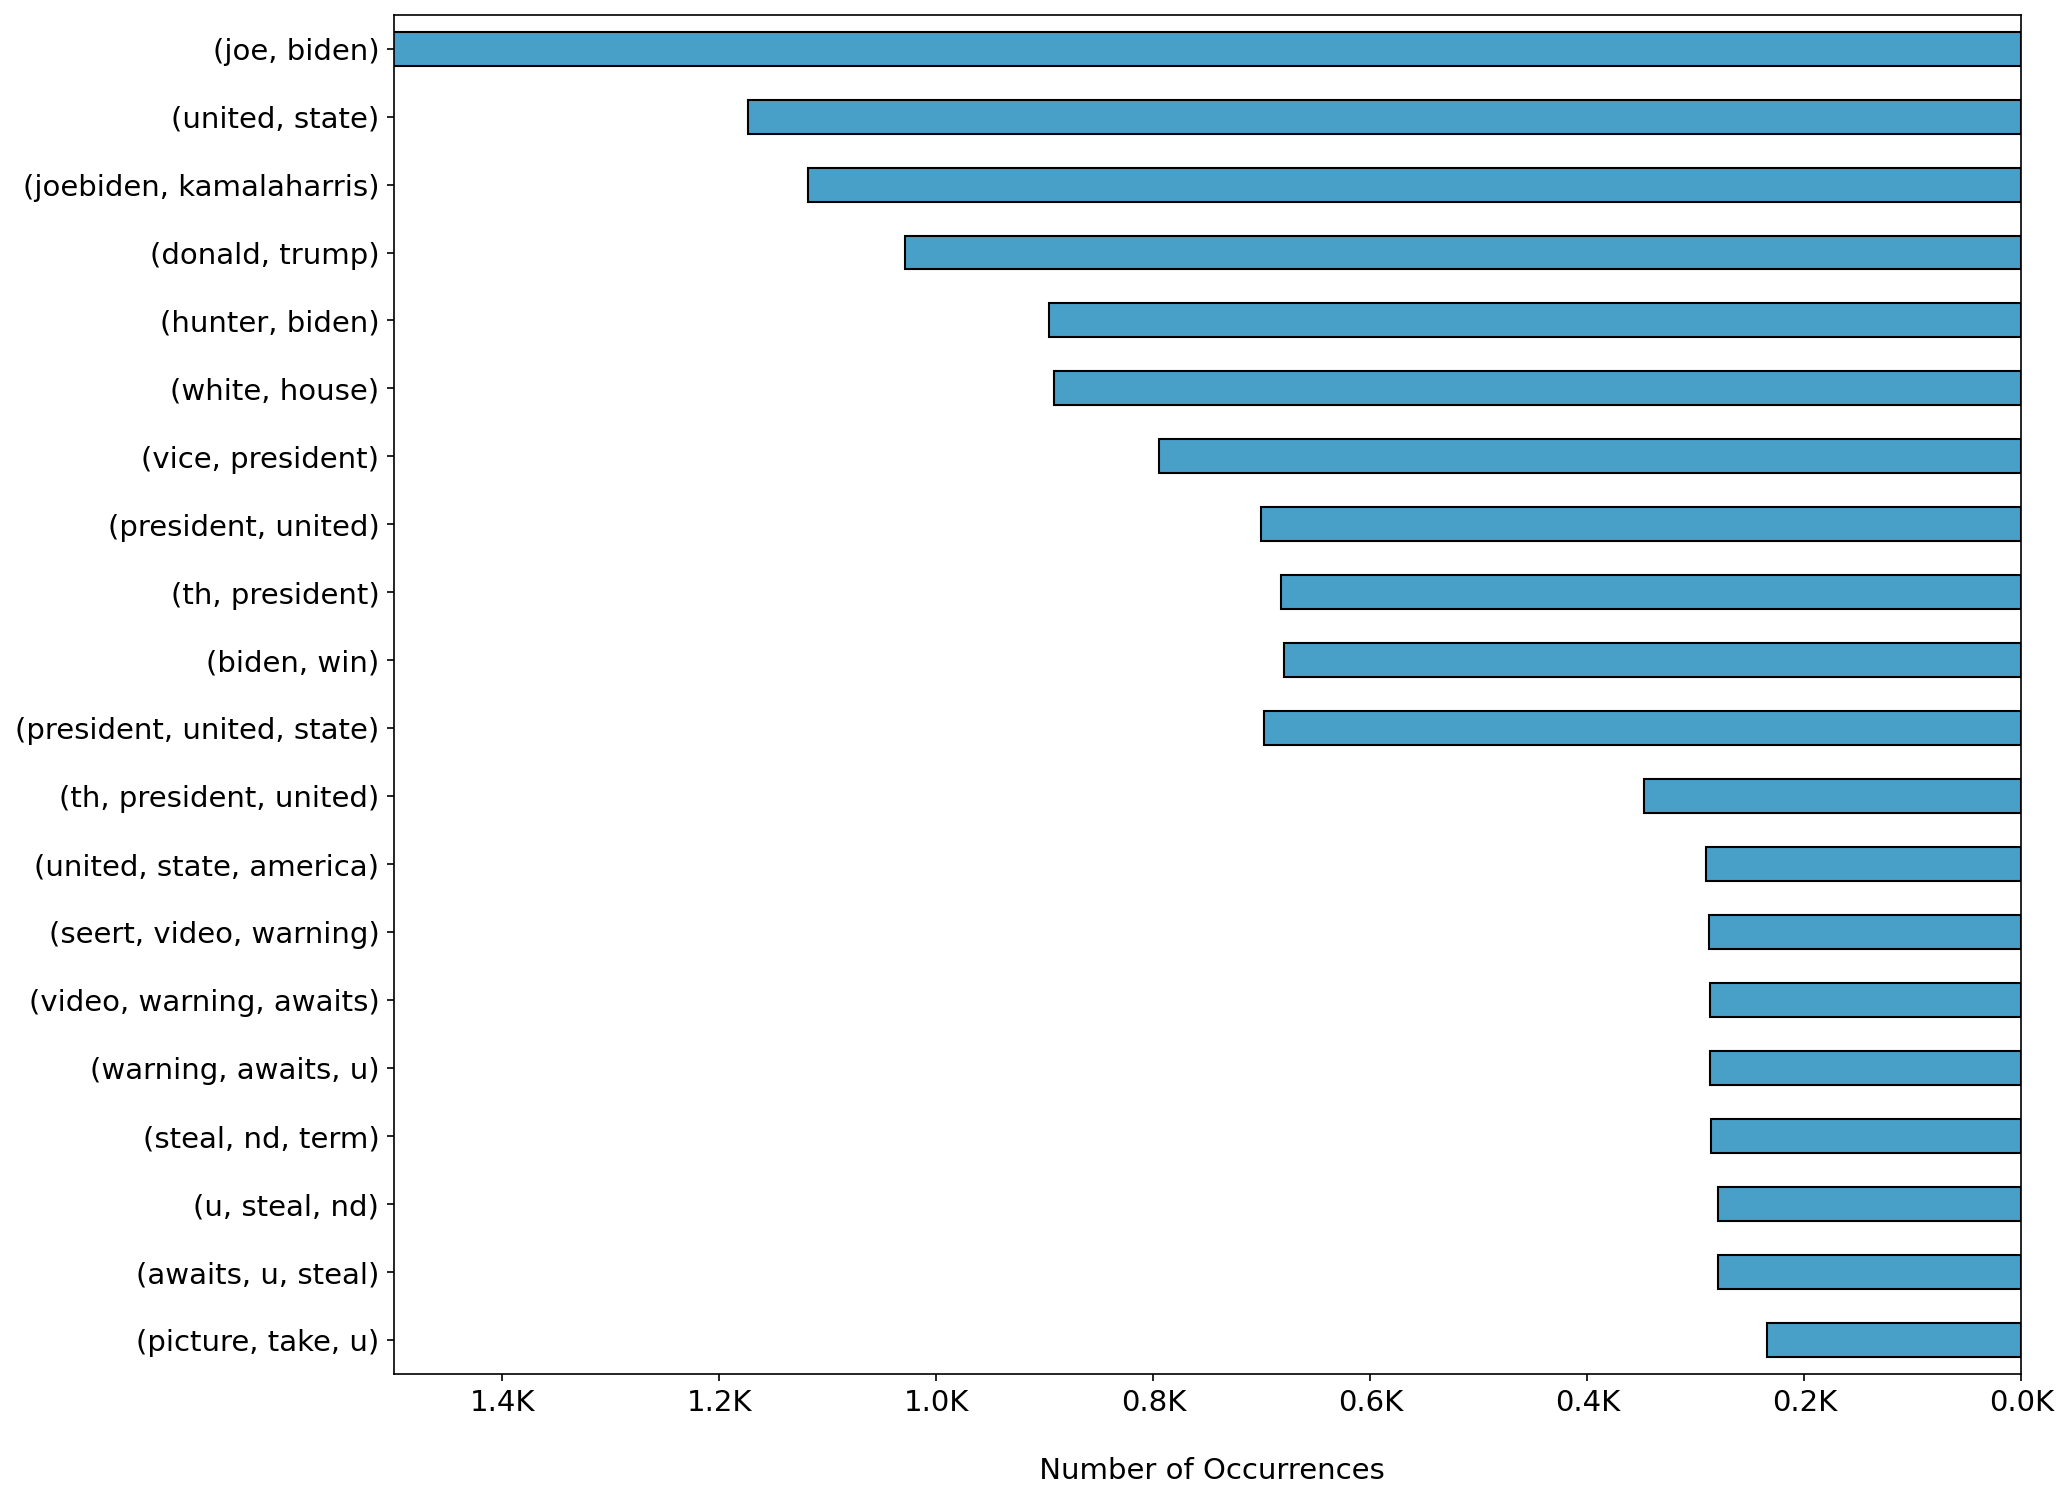

In [ ]:
fig, ax = plt.subplots(figsize=(14, 12), dpi=150)
barh_ax=ax

biden_ngrams[::-1].plot.barh(ax=ax ,color=barcolors[3],**barstyle)
barh_ax.yaxis.set_label_position("right")
barh_ax.xaxis.tick_bottom()
barh_ax.xaxis.set_label_position("bottom")
barh_ax.xaxis.set_major_formatter(formatterK2)
barh_ax.set_xlim([0, 1500])
barh_ax.set_xlim(barh_ax.get_xlim()[::-1])
barh_ax.set_xlabel('\n Number of Occurrences')

plt.rcParams.update({'font.size': 15})
plt.show()

Word Cloud

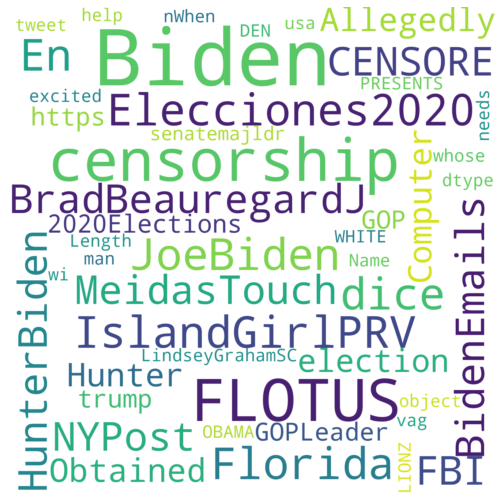

In [ ]:
plt.subplots(1,1, figsize=(9,9))
wc_b = WordCloud(stopwords=STOPWORDS, 
                 background_color="white", max_words=2000,
                 max_font_size=256, random_state=42,
                 width=1600, height=1600)
wc_b.generate(str(text1.dropna()))
plt.imshow(wc_b, interpolation="bilinear")
plt.axis('off')
plt.show()

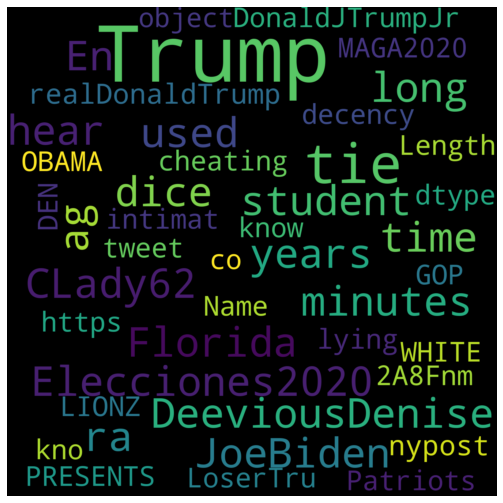

In [ ]:
plt.subplots(1,1, figsize=(9,9))
wc_t = WordCloud(stopwords=STOPWORDS, 
                 background_color="black", max_words=2000,
                 max_font_size=256, random_state=42,
                 width=1600, height=1600)
wc_t.generate(str(text2.dropna()))
plt.imshow(wc_t, interpolation="bilinear")
plt.axis('off')
plt.show()

In [ ]:
trump_df_init =  pd.read_csv("/content/drive/MyDrive/MASTERS FOLDER/CS855/US_Elections_Data_Downloads/US_elections/hashtag_donaldtrump.csv", lineterminator='\n')
biden_df_init = pd.read_csv("/content/drive/MyDrive/MASTERS FOLDER/CS855/US_Elections_Data_Downloads/US_elections/hashtag_joebiden.csv", lineterminator='\n')

biden_df = biden_df_init[biden_df_init['country'] == 'United States of America'].copy()
trump_df = trump_df_init[trump_df_init['country'] == 'United States of America'].copy()
biden_df.loc[175650]["tweet"]

"#JoeBiden is enlisting A-list star power to help close out campaign season! Do y'all think this #BradPitt appearance move the needle?? https://t.co/XJ96dlxSqP"

In [ ]:
biden_df.loc[:,'who'] = 'biden'
trump_df.loc[:,'who'] = 'trump'
data = pd.concat([biden_df, trump_df])

In [ ]:
def _calculate_languages_ratios(text):
    languages_ratios = {}

    tokens = wordpunct_tokenize(text)
    words = [word.lower() for word in tokens]

    # Compute per language included in nltk number of unique stopwords appearing in analyzed text
    for language in stopwords.fileids():
        stopwords_set = set(stopwords.words(language))
        words_set = set(words)
        common_elements = words_set.intersection(stopwords_set)

        languages_ratios[language] = len(common_elements) # language "score"

    return languages_ratios

def detect_language(text):
    ratios = _calculate_languages_ratios(text)

    most_rated_language = max(ratios, key=ratios.get)

    return most_rated_language

In [ ]:
import sys, os
import re
from tqdm.auto import tqdm
from nltk import word_tokenize, wordpunct_tokenize
from nltk.corpus import stopwords

import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Filtering

In [ ]:
def filter_english_one_to_one(df, who):
    tweets = df.query(f'who == "{who}" and state_code == state_code').sort_values('user_followers_count',ascending=False).drop_duplicates(['user_name'])[['tweet','long','lat','state_code']]
    languages = [detect_language(val) for val in tqdm(tweets.tweet)]
    filtered = tweets.loc[np.array(languages) == 'english']
    return filtered

def filter_english_sample_100(df, who):
    tweets = df.query(f'who == "{who}" and state_code == state_code').sort_values('user_followers_count',ascending=False)[['user_id','tweet','long','lat','state_code']]
    tweets = tweets.groupby("user_id").apply(
        lambda group_df: group_df.sample(100) if len(group_df) > 100 else group_df
    ).reset_index(drop=True)
    languages = [detect_language(val) for val in tqdm(tweets.tweet)]
    filtered = tweets.loc[np.array(languages) == 'english']
    return filtered

In [ ]:
filt_biden_df = filter_english_one_to_one(data, 'biden')

  0%|          | 0/52159 [00:00<?, ?it/s]

In [ ]:
filt_trump_df = filter_english_one_to_one(data, 'trump')

  0%|          | 0/40825 [00:00<?, ?it/s]

Cleaning up Tweets

In [ ]:
def tweet_clean_up(df):
    remove_links = lambda txt: re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', txt)
    remove_special = lambda txt: re.sub(r'[^a-zA-Z0-9!,.\'\"\?\-\s]', '', txt)
    remove_newline = lambda txt: re.sub(r'\n', ' ', txt)
    df['tweet'] = df['tweet'].apply(lambda x: remove_newline(remove_special(remove_links(x))))
    return df

def tweet_clean_up2(x):
    remove_links = lambda txt: re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', txt)
    remove_special = lambda txt: re.sub(r'[^a-zA-Z0-9!,.\'\"\?\-\s]', '', txt)
    remove_newline = lambda txt: re.sub(r'\n', ' ', txt)
    
    return x.apply(lambda x: remove_newline(remove_special(remove_links(x))))
    

In [ ]:
#tweet_clean_up2("Count how many times #Trump says China... #LPTVDebateTakes")

In [ ]:
cleaned_biden = tweet_clean_up(filt_biden_df)
cleaned_trump = tweet_clean_up(filt_trump_df)

In [ ]:
cleaned_biden.loc[:,'sentiment'] = 0
cleaned_trump.loc[:,'sentiment'] = 0

In [ ]:
cleaned_biden.to_csv("/content/drive/MyDrive/MASTERS FOLDER/CS855/US_Elections_Data_Downloads/US_elections/cleaned_sample_100_biden.csv", index=False, header=True)
cleaned_trump.to_csv("/content/drive/MyDrive/MASTERS FOLDER/CS855/US_Elections_Data_Downloads/US_elections/cleaned_sample_100_trump.csv", index=False, header=True)

Reading the cleaned data

In [ ]:
B_df = pd.read_csv("/content/drive/MyDrive/MASTERS FOLDER/CS855/US_Elections_Data_Downloads/US_elections/cleaned_sample_100_biden.csv")
T_df = pd.read_csv("/content/drive/MyDrive/MASTERS FOLDER/CS855/US_Elections_Data_Downloads/US_elections/cleaned_sample_100_trump.csv")

In [ ]:
B_df.loc[:,'who'] = 'biden'
T_df.loc[:,'who'] = 'trump'

balance_data_df = pd.DataFrame(columns=B_df.columns)
balance_data_df

,tweet,long,lat,state_code,sentiment,who


In [ ]:
# Northern Mariana Islands, Guam, Puerto Rico, Virgin Islands, Alaska, U.S. Minor Outlying Islands are removes because they are terroritory not electoral states

states_list = set(B_df['state_code']).union(set(T_df['state_code'])) - set(['MP', 'GU', 'PR', 'VI', 'AS', 'UM', ])

In [ ]:
for state in states_list:
    T_df_state = T_df[T_df['state_code']==state]
    B_df_state = B_df[B_df['state_code']==state]
    
    n_sample = len(T_df_state) if len(T_df_state) < len(B_df_state) else len(B_df_state)
    
    if len(T_df_state) < len(B_df_state):
        balance_data_df = pd.concat([balance_data_df, T_df_state])
        balance_data_df = pd.concat([balance_data_df, B_df_state.sample(len(T_df_state))])
    else:
        balance_data_df = pd.concat([balance_data_df, B_df_state])
        balance_data_df = pd.concat([balance_data_df, T_df_state.sample(len(B_df_state))])

In [ ]:
balance_data_df

,tweet,long,lat,state_code,sentiment,who
20,ElectionProtection Hotline sees surge over all...,-84.390185,33.749099,GA,0,trump
25,Ben Shapiro was a never-Trumper for a long tim...,-84.233809,33.544278,GA,0,trump
45,Supporters for President Trump have gathered a...,-84.390185,33.749099,GA,0,trump
81,The 10 worst things Donald Trump has done in h...,-84.390185,33.749099,GA,0,trump
124,StayWoke Trump has resumed his super spreader ...,-84.390185,33.749099,GA,0,trump
...,...,...,...,...,...,...
19304,My anxiety is at a all time high with this ele...,-122.192337,47.614422,WA,0,biden
39746,"First and foremost, I'd like to congratulate ...",-122.330062,47.603832,WA,0,biden
38044,hannahnatanson johncusack This is nice but I c...,-122.330062,47.603832,WA,0,biden
16004,"Monday, Joe Biden JillBiden, Sen. KamalaHarris...",-122.330062,47.603832,WA,0,biden


In [ ]:
batch_size = 100

In [ ]:
from tqdm.auto import tqdm
import tensorflow as tf

def emotion_classify(tweet_list):
    batch_idx = np.append(np.arange(0, len(tweet_list), batch_size), len(tweet_list))
    labels = np.array([])
    for i in tqdm(range(len(batch_idx)-1)):
        tf_batch = tokenizer(tweet_list[batch_idx[i]:batch_idx[i+1]], max_length=280, padding=True, truncation=True, return_tensors='tf')
        tf_outputs = model(tf_batch)
        tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1)
        labels = np.append(labels, tf.argmax(tf_predictions, axis=1))
#         labels = np.append(labels, tf_predictions[:,1])
        del tf_batch
    return labels

Number of States and DC

In [ ]:
len(states_list)


51

In [ ]:
dem_states = set(['DC', 'VT', 'HI', 'MA', 'MD', 'CA', 'NY', 'RI', 'DE', 
                 'CT', 'WA', 'ME', 'NJ', 'OR', 'IL'])
rep_states = set(['OH', 'IA', 'TX', 'MT', 'SC', 'AK', 'MO', 'IN', 'NE',
                 'KS', 'UT', 'MS', 'TN', 'SD', 'KY', 'LA', 'AL', 'ND',
                 'ID', 'AR', 'OK', 'WV', 'WY'])
swing_states = states_list - dem_states - rep_states

swing_states

{'AZ', 'CO', 'FL', 'GA', 'MI', 'MN', 'NC', 'NH', 'NM', 'NV', 'PA', 'VA', 'WI'}

In [ ]:
electoral_vote_by_state = pd.read_csv("/content/drive/MyDrive/MASTERS FOLDER/CS855/US_Elections_Data_Downloads/US_elections/electoral_vote_by_state.csv")



In [ ]:
states_results = pd.DataFrame(columns=['state_code', 'biden', 'trump', 'type', 'winner'])

In [ ]:
states_results.loc[:,'state_code'] = electoral_vote_by_state['state_code']
states_results.loc[:,'e_vote'] = electoral_vote_by_state['e_vote']

In [ ]:
type_vs_candidate = {'blue': 'biden', 'red': 'trump', 'purple': 'contentious'}
threshold = 1.15
for state in states_list:
    trump_slice = balance_data_df.query(f'state_code == "{state}" and who == "trump"')
    biden_slice = balance_data_df.query(f'state_code == "{state}" and who == "biden"')
    trump_score = np.sum(trump_slice['sentiment']) + 1
    biden_score = np.sum(biden_slice['sentiment']) + 1
    
    state_type = ''
    if state in dem_states:
        state_type = 'blue'
    elif state in rep_states:
        state_type = 'red'
    else:
        state_type = 'purple'
        
    winner = ''
    if len(trump_slice) + len(biden_slice) < 1000:
        winner = type_vs_candidate[state_type]
    else:
        if trump_score/biden_score > threshold:
            winner = 'trump'
        elif biden_score/trump_score > threshold:
            winner = 'biden'
        else:
            winner = 'contentious'
        
    states_results.loc[states_results['state_code'] == state, ['biden', 'trump', 'type', 'winner']] = \
        [biden_score, trump_score, state_type, winner]

In [ ]:
states_results.query('type=="blue" and winner=="Biden"')

,state_code,biden,trump,type,winner,e_vote


In [ ]:
states_results.query('type=="red" and winner=="Trump"')

,state_code,biden,trump,type,winner,e_vote


In [ ]:
states_results.query('winner=="contentious"')

,state_code,biden,trump,type,winner,e_vote
4,AZ,1,1,purple,contentious,11
5,NV,1,1,purple,contentious,6
7,NH,1,1,purple,contentious,4
8,CA,1,1,blue,contentious,55
9,NJ,1,1,blue,contentious,14
10,CO,1,1,purple,contentious,9
11,NM,1,1,purple,contentious,5
13,NY,1,1,blue,contentious,29
15,NC,1,1,purple,contentious,15
16,DC,1,1,blue,contentious,3


In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

In [ ]:
us_shape = gpd.read_file('/content/drive/MyDrive/MASTERS FOLDER/CS855/US_Elections_Data_Downloads/US_elections/us_shape/cb_2018_us_state_20m.shp')

In [ ]:
us_shape = us_shape[['STUSPS', 'geometry']]

In [ ]:
states_results_tmp = states_results.copy()
states_results_tmp = states_results_tmp.merge(us_shape, left_on='state_code', right_on='STUSPS')
states_results_tmp.drop(['STUSPS'], axis=1, inplace=True)
states_results_tmp = gpd.GeoDataFrame(states_results_tmp)
states_results_tmp.columns

Index(['state_code', 'biden', 'trump', 'type', 'winner', 'e_vote', 'geometry'], dtype='object')

US Map

[]

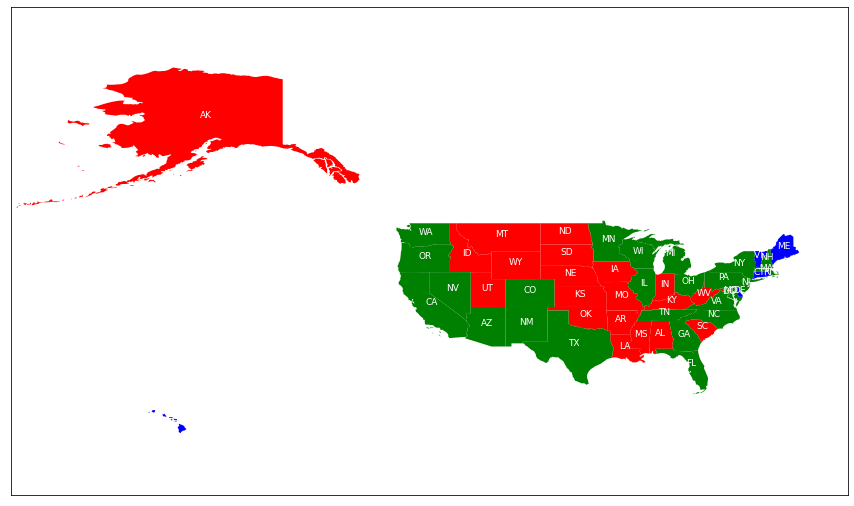

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15,15))
states_results_tmp.apply(lambda x: ax.annotate(s=x.state_code, xy=x.geometry.centroid.coords[0], ha='center', fontsize=9, color='white'),axis=1);
states_results_tmp[states_results_tmp['winner'] == 'trump'].plot(ax=ax, color='red')
states_results_tmp[states_results_tmp['winner'] == 'biden'].plot(ax=ax, color='blue')
states_results_tmp[states_results_tmp['winner'] == 'contentious'].plot(ax=ax, color='green')
plt.axis('square')
ax.set_xlim([-180, -60])
ax.set_ylim([10, 80])
ax.set_xticks([])
ax.set_yticks([])

In [ ]:
trump_vote = np.sum(states_results[states_results['winner'] == 'trump']['e_vote'])
biden_vote = np.sum(states_results[states_results['winner'] == 'biden']['e_vote'])
print(trump_vote, biden_vote)

121 25


In [ ]:
import itertools

In [ ]:
states_results = pd.read_csv('/content/drive/MyDrive/MASTERS FOLDER/CS855/US_Elections_Data_Downloads/US_elections/state_results_100_conti.csv')

In [ ]:
contentious_states = states_results.loc[states_results['winner'] == 'contentious',['state_code', 'e_vote']]
contentious_states

,state_code,e_vote
0,AL,9
4,AZ,11
5,NV,6
7,NH,4
8,CA,55
9,NJ,14
10,CO,9
11,NM,5
12,CT,7
13,NY,29


In [ ]:
get_bin = lambda x, n: format(x, 'b').zfill(n)

In [ ]:
def predict_winner(states, win_lose):
    trump_cont_vote = trump_vote + np.sum(states.iloc[np.where(np.array(win_lose) == 1)[0]]['e_vote'])
    biden_cont_vote = biden_vote + np.sum(states.iloc[np.where(np.array(win_lose) == 0)[0]]['e_vote'])
    
#     print(trump_cont_vote, biden_cont_vote)
    
    if trump_cont_vote >= num_vote_to_win:
        return 1
    elif biden_cont_vote >= num_vote_to_win:
        return 0
    else:
        return None

In [ ]:
num_vote_to_win = 270
trump_vote = np.sum(states_results[states_results['winner'] == 'trump']['e_vote'])
biden_vote = np.sum(states_results[states_results['winner'] == 'biden']['e_vote'])
print(trump_vote, biden_vote)

41 14


In [ ]:
total = 0
n_bits = len(contentious_states)
n_possible_scenarios = 2**n_bits
draw = 0
for i in range(n_possible_scenarios):
    win_lose = list(map(int, get_bin(i, n_bits)))
    
    winner = predict_winner(contentious_states, win_lose)
    if winner != None:
        total += winner
    else:
        draw += 1

KeyboardInterrupt: ignored